# Particle-COMETS: From dynamic FBA to spatial simulations with particles
Eran Agmon, University of Connecticut

This notebook is dedicated to developing a particle-COMETS simulation step by step using Vivarium.
Each section of this notebook incrementally adds layers to our model, illustrating the different computational methods and how they integrate.

In [1]:
import numpy as np
from spatio_flux import (
    SpatioFluxVivarium, # spatio-flux's customized Vivarium
    render_path
)

## Make a Vivarium
view available types and processes

In [2]:
# make a fresh vivarium
vi = SpatioFluxVivarium()

In [3]:
# view the available types
vi.get_types()

['',
 'float',
 'boolean',
 'current^2*time^3/length^2*mass',
 'length^2*mass/current^2*time^2',
 'step',
 'number',
 'length^0_5*mass^0_5',
 'length^2/time^2',
 'mass/length',
 'time',
 'length^2*mass/current*time^2',
 '/substance',
 'kinetics',
 'substance',
 'map',
 'union',
 'temperature',
 'reaction',
 'length*temperature',
 'length^0_5*mass^0_5/time',
 'luminosity/length^2',
 'printing_unit/length',
 '/length',
 'length^3/mass*time^2',
 'string',
 'length*mass/current*time^3',
 'length/time',
 'current',
 'process',
 'interval',
 'any',
 'protocol',
 'tuple',
 'length^2*mass/substance*temperature*time^2',
 'mass/time^2',
 '/temperature*time',
 'length',
 'list',
 'length^2*mass/current*time^3',
 'length^2*mass/current^2*time^3',
 'current*length^2',
 'quote',
 'path',
 'substance/length^3',
 'length^2',
 'integer',
 'current*length^2*time',
 'current*time',
 'boundary_side',
 '/printing_unit',
 'current*time/mass',
 'emitter_mode',
 'current^2*time^4/length^2*mass',
 'time^2/leng

In [4]:
# view the available processes
vi.get_processes()

['DynamicFBA',
 'Particles',
 'json-emitter',
 'console-emitter',
 'composite',
 'MinimalParticle',
 'ram-emitter',
 'DiffusionAdvection']

## dFBA

Dynamic Flux Balance Analysis (dFBA) extends traditional Flux Balance Analysis (FBA) to model the dynamic behavior of metabolic networks over time, allowing for the simulation of growth and substrate consumption in a changing environment.

In [5]:
# inspect the DynamicFBA process config
vi.process_config('DynamicFBA')

{'model_file': 'string',
 'kinetic_params': 'map[tuple[float,float]]',
 'substrate_update_reactions': 'map[string]',
 'biomass_identifier': 'string',
 'bounds': 'map[bounds]'}

In [6]:
# dfba_config  = vi.process_config('DynamicFBA', dataclass=True)  # TODO get dataclass to configure

In [7]:
# vi.process_interface('DynamicFBA')  # TODO -- make this work

In [8]:
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

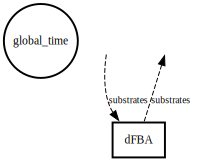

In [9]:
# make a fresh vivarium
v1 = SpatioFluxVivarium()

# add a dFBA process
v1.add_process(
    name="dFBA",
    process_id="DynamicFBA",
    config=dfba_config
)
v1.diagram(dpi='70')

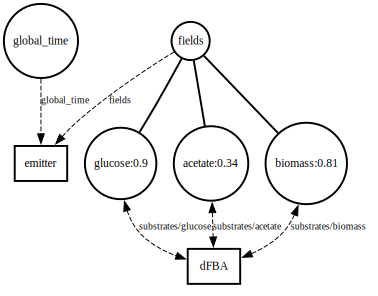

In [10]:
mol_ids = ["glucose", "acetate", "biomass"]

# add the molecular fields
for mol_id in mol_ids:
    v1.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand()
    )

v1.connect_process(
    name="dFBA",
    inputs={
            "substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}
    },
    outputs={
            "substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}
    }
)

# add an emitter to save results
v1.add_emitter()
v1.diagram(dpi='70', show_values=True)

In [11]:
v1.set_value(path=['fields', 'glucose'], value=10)
v1.set_value(path=['fields', 'biomass'], value=0.1)
field = v1.get_value(['fields'])
print(field)

{'glucose': 10, 'acetate': 0.3448650135620257, 'biomass': 0.1}


In [12]:
# save a file with the exact simulation state
v1.save(filename='dFBA_t0')

Saved file: out/dFBA_t0.json


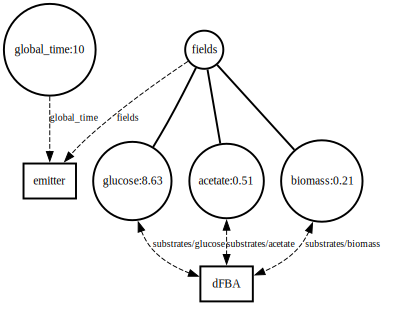

In [13]:
vx = SpatioFluxVivarium(document='out/dFBA_t0.json')
vx.run(interval=10)
vx.diagram(dpi='70', show_values=True)

In [14]:
# run the simulation
v1.run(interval=60)

In [15]:
# view the timeseries
v1.get_timeseries(as_dataframe=True)

,/global_time,/fields/glucose,/fields/acetate,/fields/biomass
0,0.0,10.000000,0.344865,0.100000
1,1.0,9.904762,0.356973,0.107943
2,2.0,9.802006,0.369949,0.116515
3,3.0,9.691146,0.383844,0.125766
4,4.0,9.571550,0.398709,0.135747
...,...,...,...,...
56,56.0,0.000000,0.000000,0.968302
57,57.0,0.000000,0.000000,0.968302
58,58.0,0.000000,0.000000,0.968302
59,59.0,0.000000,0.000000,0.968302


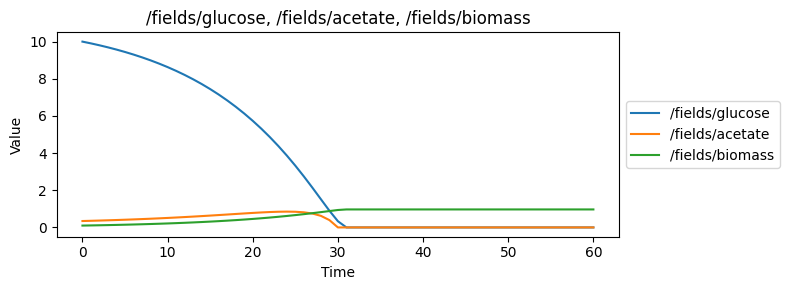

In [16]:
# plot the timeseries
v1.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [  # combine the variables into a single subplot
            '/fields/glucose',
            '/fields/acetate',
            '/fields/biomass'
        ]
    ]
)

## Spatial dFBA

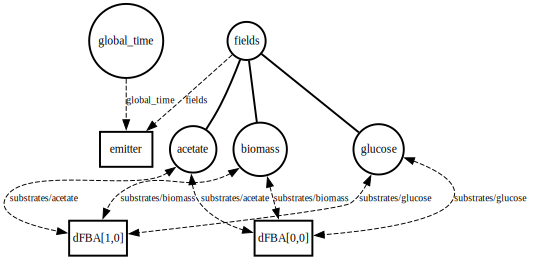

In [17]:
mol_ids = ["glucose", "acetate", "biomass"]
rows = 2
columns = 1

# make a fresh vivarium
v2 = SpatioFluxVivarium()
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config
        )
        v2.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}
            },
            outputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}
            }
        )

# add an emitter to save results
v2.add_emitter()
v2.diagram(dpi='70')

In [18]:
# change some initial values
v2.merge_value(path=['fields', 'glucose', 0, 0], value=10.0)
v2.merge_value(path=['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': array([[10.        ],
       [ 0.82668079]]), 'acetate': array([[0.84136088],
       [0.25677719]]), 'biomass': array([[0.1       ],
       [0.18647141]])}


In [19]:
# run a simulation
v2.run(60)

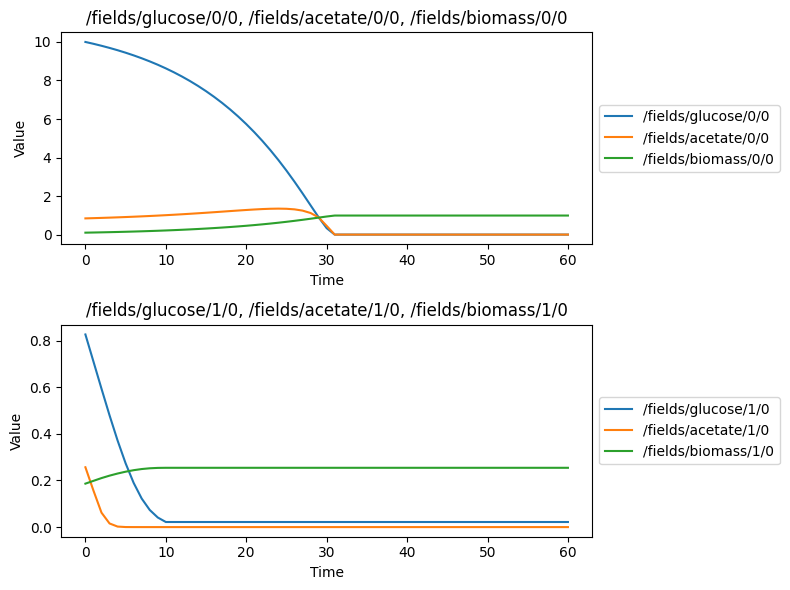

In [20]:
# get a list of all the paths so they can be plotted together in a single graph
all_paths = [
    [render_path(['fields', mol_id, i, j]) for mol_id in mol_ids]
    for i in range(rows)
    for j in range(columns)
]

# plot the timeseries
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=all_paths
)

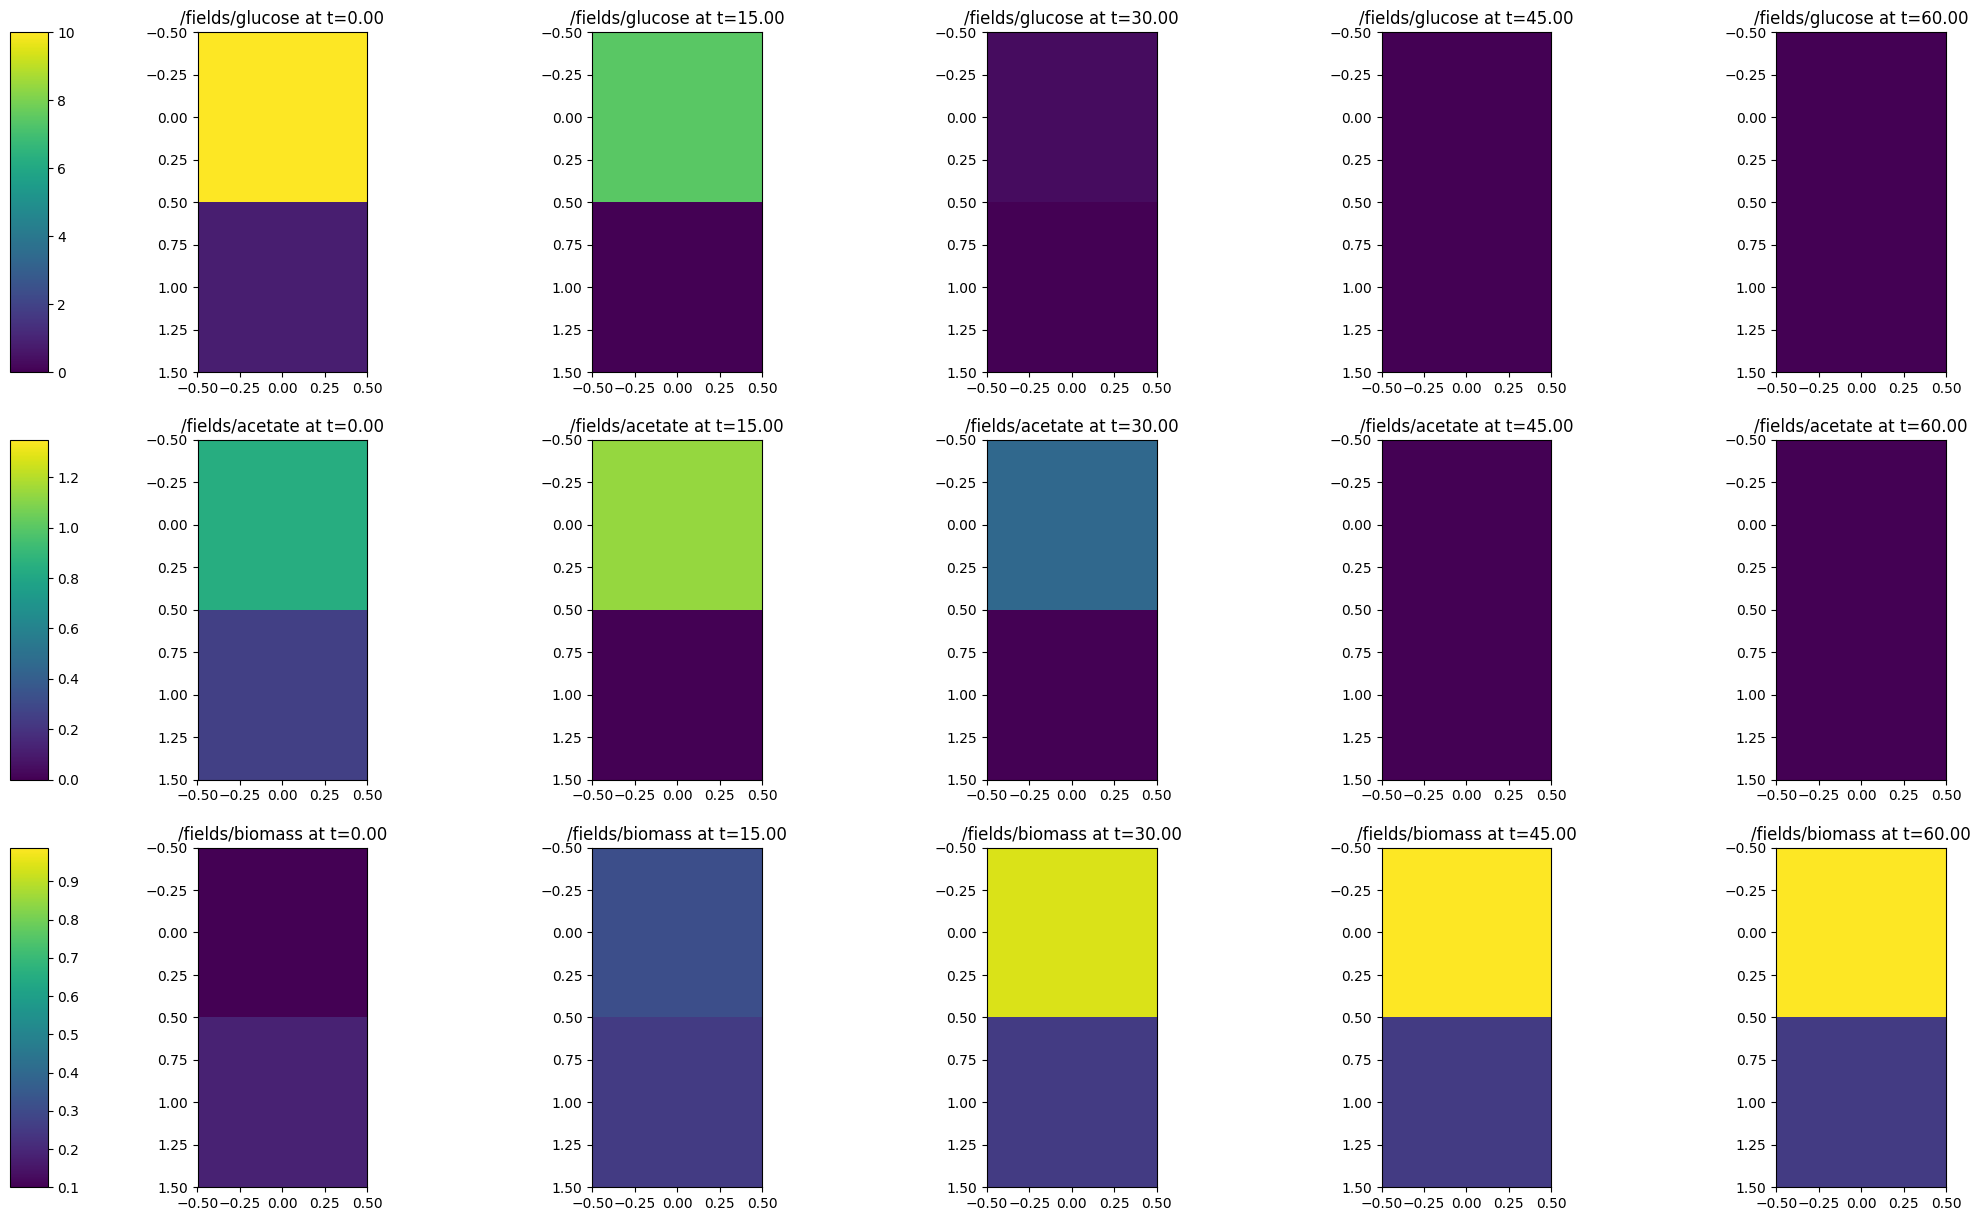

In [21]:
v2.plot_snapshots()

## Diffusion/Advection

This approach models the physical processes of diffusion and advection in two dimensions, providing a way to simulate how substances spread and are transported across a spatial domain, essential for understanding patterns of concentration over time and space.

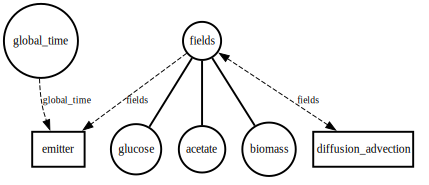

In [22]:
bounds = (10.0, 10.0)
n_bins = (10, 10)
mol_ids = [
    'glucose',
    'acetate',
    'biomass'
]
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, -0.1)
}

# make a fresh Vivarium
v3 = SpatioFluxVivarium()

# add fields for all the molecules
for mol_id in mol_ids:
    v3.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(n_bins[0], n_bins[1]))

# add a spatial diffusion advection process
v3.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs
    },
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']}
)

# add an emitter to save results
v3.add_emitter()
v3.diagram(dpi='70')

In [23]:
v3.run(60)


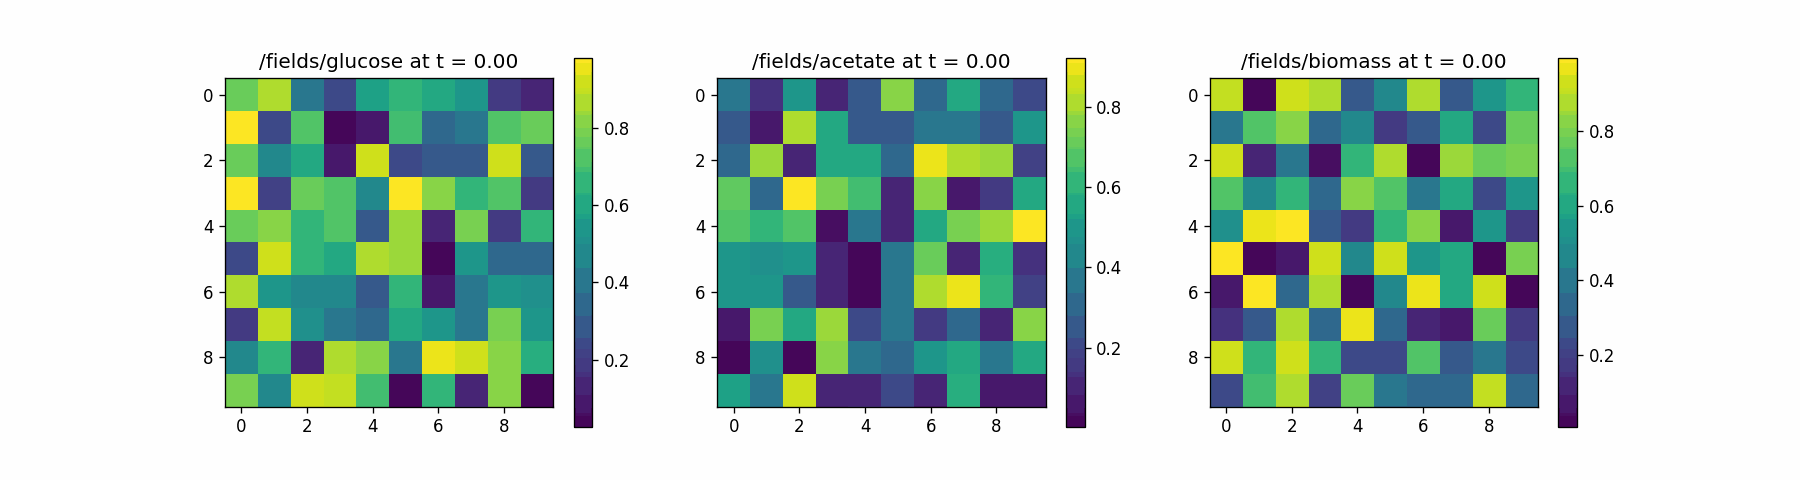

In [24]:
v3.show_video()

## COMETS (Computation Of Microbial Ecosystems in Time and Space)

COMETS combines dynamic FBA with spatially resolved physical processes (like diffusion and advection) to simulate the growth, metabolism, and interaction of microbial communities within a structured two-dimensional environment, capturing both biological and physical complexities.

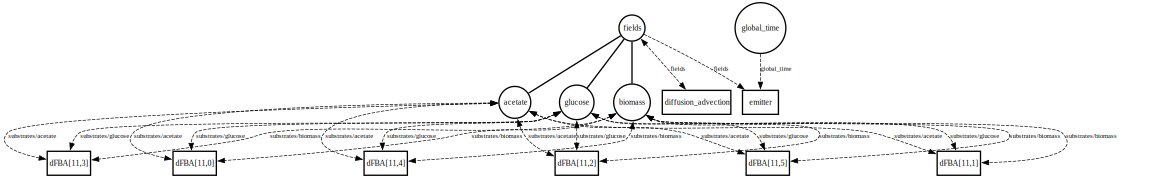

In [25]:
bounds = (20.0, 10.0)  # Bounds of the environment
n_bins = (12, 6)
mol_ids = ['glucose', 'acetate', 'biomass']
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, 0.1)
}

# make a fresh vivarium
v4 = SpatioFluxVivarium()

# initialize the molecular fields
max_glc = 10
glc_field = np.random.rand(n_bins[0], n_bins[1]) * max_glc
acetate_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field[0:int(1*n_bins[0]/5), int(2*n_bins[1]/5):int(3*n_bins[1]/5)] = 0.1  # place some biomass

v4.add_object(
    name='glucose',
    path=['fields'],
    value=glc_field
)
v4.add_object(
    name='biomass',
    path=['fields'],
    value=biomass_field
)
v4.add_object(
    name='acetate',
    path=['fields'],
    value=acetate_field
)

# add a diffusion/advection process
v4.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs
    },
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']}
)

# add a dynamic FBA process at every location
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_name = f"dFBA[{i},{j}]"
        v4.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config
        )
        v4.connect_process(
            name=dfba_name,
            inputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}
            },
            outputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}
            }
        )

# add an emitter to save results
v4.add_emitter()
v4.diagram(
    dpi='70',
    remove_nodes=[f"/dFBA[{i},{j}]" for i in range(n_bins[0]-1) for j in range(n_bins[1])]
)

In [26]:
v4.run(60)


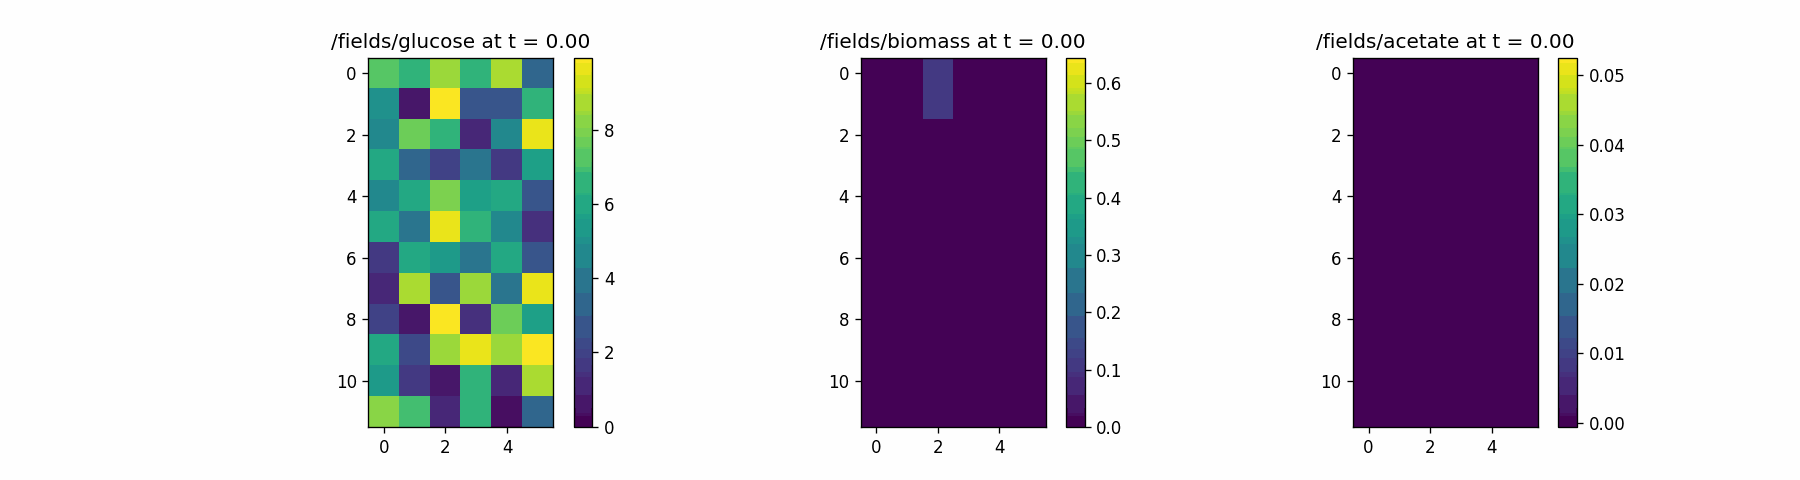

In [27]:
v4.show_video()

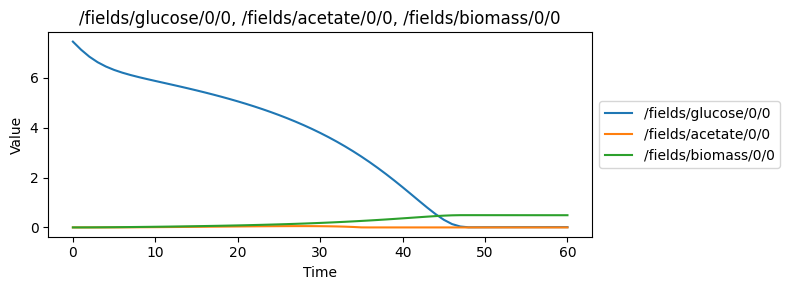

In [28]:
v4.plot_timeseries(
    subplot_size=(8, 3),
    query=[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ],
    combined_vars=[[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ]]
)

## Particles

In [1]:
import numpy as np
from spatio_flux import SpatioFluxVivarium

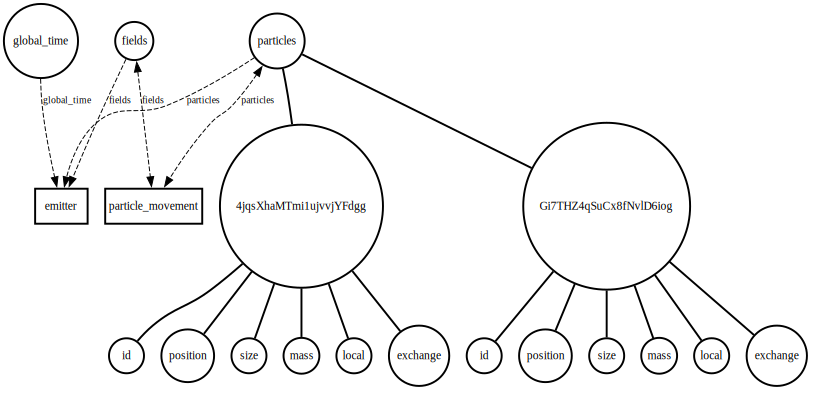

In [2]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (20, 40)  # Number of bins in the x and y directions

v5 = SpatioFluxVivarium()

v5.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.3,
        'boundary_to_add': ['top']
    },
)
v5.connect_process(
    name='particle_movement',
    inputs={
        'fields': ['fields'],
        'particles': ['particles']
    },
    outputs={
        'fields': ['fields'],
        'particles': ['particles']
    }
)

v5.initialize_process(
    path='particle_movement',
    config={'n_particles': 2}
)

v5.add_emitter()
v5.diagram(dpi='70')

In [3]:
v5.save('particle_movement')

Saved file: out/particle_movement.json


In [4]:
v5.run(100)
v5_results = v5.get_results()

Saving GIF to species_distribution_with_particles.gif



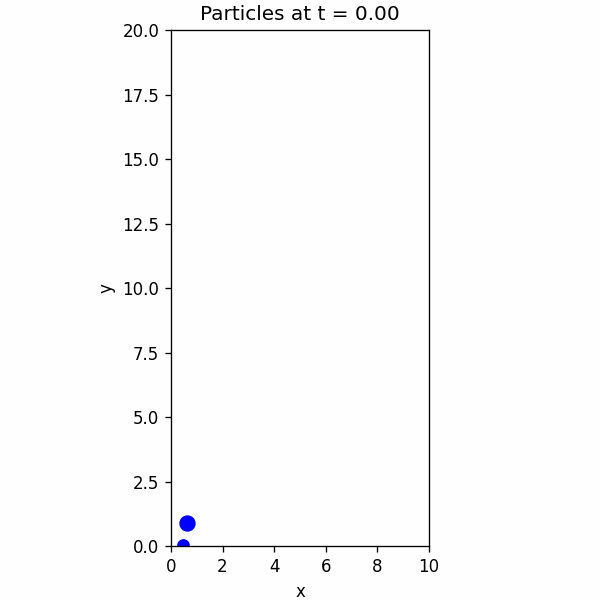

In [5]:
v5.plot_particles_snapshots(skip_frames=3)

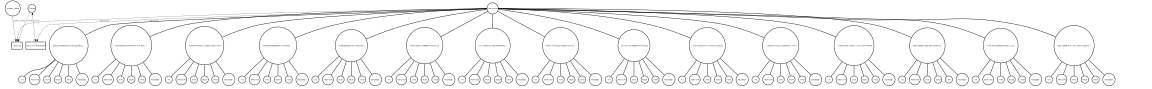

In [6]:
v5.diagram(dpi='70')

In [7]:
v5.save(filename='v5_post_run.json', outdir='out')

Saved file: out/v5_post_run.json


## Minimal particle process

In [8]:
from spatio_flux.processes.particles import get_minimal_particle_composition

In [ ]:
# get the document from the last simulation and start a new simulation from it
document = v5.make_document()
v6 = SpatioFluxVivarium(document=document)

# remove all particles but one
particle_ids = list(v6.get_value(path=['particles']).keys())
v6.apply_value(path=['particles'], value={'_remove': particle_ids[1:]})

particle_schema = get_minimal_particle_composition(v6.core)
v6.merge_schema(path=['particles'], schema=particle_schema['particles'])

v6.add_object(
    name='glucose',
    path=['fields'],
    value=np.random.rand(n_bins[0], n_bins[1])
)

v6.diagram(dpi='70')

In [10]:
v6.composite.composition['particles']['_value']

{'id': {'_type': 'string',
  '_default': '',
  '_check': 'check_string',
  '_apply': 'replace',
  '_serialize': 'serialize_string',
  '_deserialize': 'deserialize_string',
  '_dataclass': 'dataclass_string',
  '_description': '64-bit integer'},
 'position': {'_type': 'tuple',
  '_default': 'default_tuple',
  '_apply': 'apply_tuple',
  '_check': 'check_tuple',
  '_slice': 'slice_tuple',
  '_serialize': 'serialize_tuple',
  '_deserialize': 'deserialize_tuple',
  '_dataclass': 'dataclass_tuple',
  '_fold': 'fold_tuple',
  '_divide': 'divide_tuple',
  '_bind': 'bind_tuple',
  '_description': 'tuple of an ordered set of typed values',
  '_type_parameters': ['0', '1'],
  '_0': 'float',
  '_1': 'float'},
 'size': {'_type': 'float',
  '_check': 'check_float',
  '_apply': 'accumulate',
  '_serialize': 'to_string',
  '_description': '64-bit floating point precision number',
  '_default': 0.0,
  '_deserialize': 'deserialize_float',
  '_divide': 'divide_float',
  '_dataclass': 'dataclass_float',
 

In [11]:
v6.run(60)  # document is not getting deserialized?
v6_results = v6.get_results()

Saving GIF to species_distribution_with_particles.gif



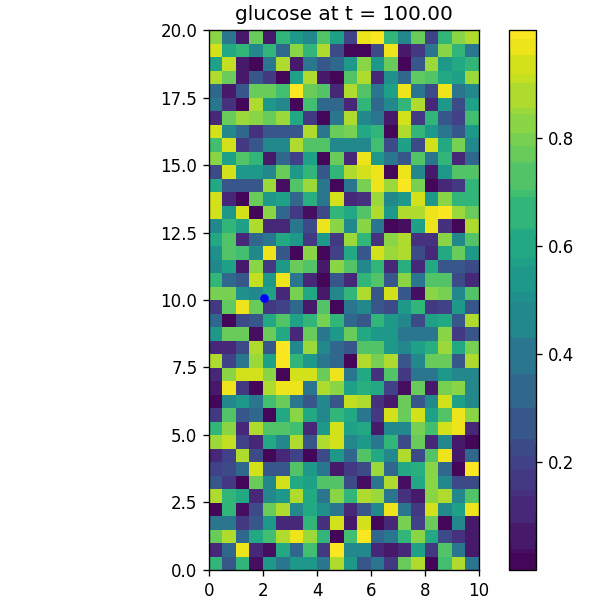

In [12]:
v6.plot_particles_snapshots(skip_frames=3)

## Particle-COMETS